In [1]:
import cv2
from os.path import isfile, join
import numpy as np
import dlib




In [36]:
face_rec_model_path='models/dlib_face_recognition_resnet_model_v1.dat'
predictor_path = 'models/landmarks.dat'

detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor(predictor_path)
facerec = dlib.face_recognition_model_v1(face_rec_model_path)


In [37]:
import glob, os
features =[]
images=[]

cap = cv2.VideoCapture('test.mp4')
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break
    img = frame


    # Ask the detector to find the bounding boxes of each face. The 1 in the
    # second argument indicates that we should upsample the image 1 time. This
    # will make everything bigger and allow us to detect more faces.
    dets = detector(img, 1)
    print("Number of faces detected: {}".format(len(dets)))

    # Now process each face we found.
    for k, d in enumerate(dets):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))
        # Get the landmarks/parts for the face in box d.
        shape = sp(img, d)
        # Compute the 128D vector that describes the face in img identified by
        # shape.  In general, if two face descriptor vectors have a Euclidean
        # distance between them less than 0.6 then they are from the same
        # person, otherwise they are from different people. Here we just print
        # the vector to the screen.
        features.append(facerec.compute_face_descriptor(img, shape))
        images.append(frame)
cap.release()
cv2.destroyAllWindows()        

features = np.array(features)        


Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 0
Number of faces detected: 1
Detection 0: Left: 324 Top: 98 Right: 510 Bottom: 284
Number of faces detected: 1
Detection 0: Left: 339 Top: 116 Right: 494 Bottom: 270
Number of faces detected: 0
Number of faces detected: 1
Detection 0: Left: 324 Top: 118 Right: 510 Bottom: 304
Number of faces detected

In [38]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
reduced = tsne.fit_transform(features)

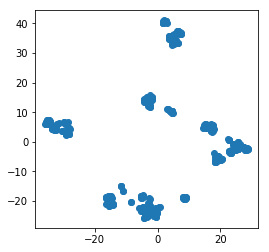

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(4, 4))
plt.scatter(x = reduced[:,0], y=reduced[:,1])
plt.show()



In [40]:
from tensorflow.contrib.tensorboard.plugins import projector

In [41]:
LOG_DIR = '/Users/anshu/meet-up/internship/recognition/face-embeddings/embeddings-logs/'

In [42]:
import pickle
np.savetxt(LOG_DIR+'feature_vectors_400_samples.txt',features)
pickle.dump(features, open(LOG_DIR+'feature_vectors_400_samples.pkl', 'wb'))

In [47]:
img_data=[]
for img in images:
    input_img = img
    input_img_resize=cv2.resize(input_img,(400,400))
#     backtorgb = cv2.cvtColor(input_img_resize,cv2.COLOR_BGR2RGB)
    img_data.append(input_img_resize)
    
                
img_data = np.array(img_data)


In [48]:
import tensorflow as tf
import os
feature_vectors = np.loadtxt(LOG_DIR+'feature_vectors_400_samples.txt')
print ("feature_vectors_shape:",feature_vectors.shape)
print ("num of images:",feature_vectors.shape[0])
print ("size of individual feature vector:",feature_vectors.shape[1])
features = tf.Variable(feature_vectors, name='features')



metadata_file = open(os.path.join(LOG_DIR, 'metadata_4_classes.tsv'), 'w')
metadata_file.write('Class\tName\n')

    
metadata_file.close()

feature_vectors_shape: (400, 128)
num of images: 400
size of individual feature vector: 128


In [49]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding

    Args:
      data: NxHxW[x3] tensor containing the images.

    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
    # Inverting the colors seems to look better for MNIST
#     data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data
#%%
sprite = images_to_sprite(img_data)
cv2.imwrite(os.path.join(LOG_DIR, 'sprite_4_classes.png'), sprite)

True

In [50]:
with tf.Session() as sess:
    saver = tf.train.Saver([features])

    sess.run(features.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'images_4_classes.ckpt'))
    
    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = features.name
    # Link this tensor to its metadata file (e.g. labels).
#     embedding.metadata_path = os.path.join(LOG_DIR, 'metadata_4_classes.tsv')
    # Comment out if you don't want sprites
    embedding.sprite.image_path = os.path.join(LOG_DIR, 'sprite_4_classes.png')
    embedding.sprite.single_image_dim.extend([img_data.shape[1], img_data.shape[1]])
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)